In [1]:
%matplotlib inline
from ztfquery import query
import numpy as np
import datetime
from tqdm import tqdm


In [2]:
class MultiNightSummary(query._ZTFTableHandler_):
    
    def __init__(self, start_date=None, end_date=None):
        self.nights = self.find_nights(start_date, end_date)
        
        print("Using {0} Nightly Sumaries between {1} and {2}".format(
            len(self.nights), self.nights[0], self.nights[-1]))
        
        self.data, self.missing_nights = self.stack_nights()
        
        print("Of these, {0} nights are missing because ZTF did not observe.".format(len(self.missing_nights)))
        
    @staticmethod
    def find_nights(start_date=None, end_date=None):
        date_format = "%Y%m%d"
    
        if start_date is None:
            now = datetime.datetime.now()
            start_time = now - datetime.timedelta(days=30)
        else:
            start_time = datetime.datetime.strptime(start_date, date_format).time()
        if end_date is None:
            end_time = datetime.datetime.now()
        else:
            end_time = datetime.datetime.strptime(end_date, date_format).time()
            
        if start_time > end_time:
            raise ValueError("Start time {0} occurs after end time {1}.".format(start_time, end_time))

        delta_t = (end_time - start_time).days
        
        dates = [(start_time + datetime.timedelta(days=x)).strftime(date_format) for x in range(0, delta_t + 1)]
        
        return dates
        
    def stack_nights(self):
        ns = None
        missing_nights = []
    
        for night in tqdm(self.nights):
            new_ns = self.get_ztf_data(night)
            
            if ns is None:
                ns = new_ns

            if new_ns is not None:
                ns.data = ns.data.append(new_ns.data)
            else:
                missing_nights.append(night)
                
        return ns.data, missing_nights
    
    @staticmethod
    def get_ztf_data(date=None):
        """Function to grab data for a given date using ztfquery. 
        Date should be given in format YYYYMMDD, with the day being the UT day for the END of the night.
        By default, today is selected. Returns a NightSummary if one is available, or None otherwise 
        (None is returned if there are no ZTF observations).
        """
        if date is None:
            print("No date specified. Assuming today.")
            now = datetime.datetime.now()
            date = now.strftime("%Y%m%d")
        try:
            return query.NightSummary(date)
        # query returns an index error is no ztf data is found
        except IndexError:
            return None

In [3]:
mns = MultiNightSummary()

  0%|          | 0/31 [00:00<?, ?it/s]

Using 31 Nightly Sumaries between 20190610 and 20190710


100%|██████████| 31/31 [00:28<00:00,  1.09it/s]

Of these, 2 nights are missing because ZTF did not observe.


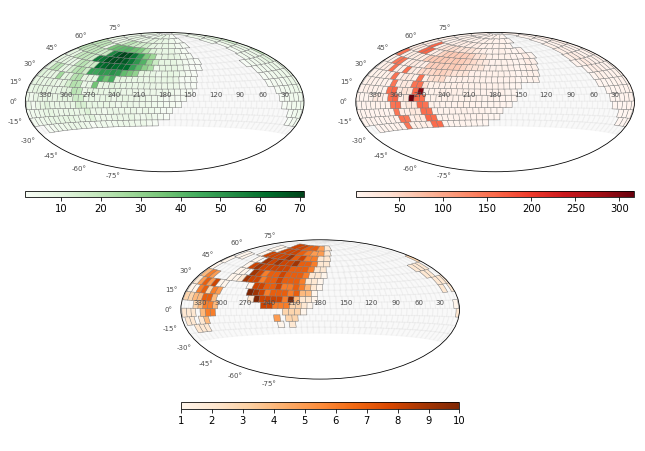

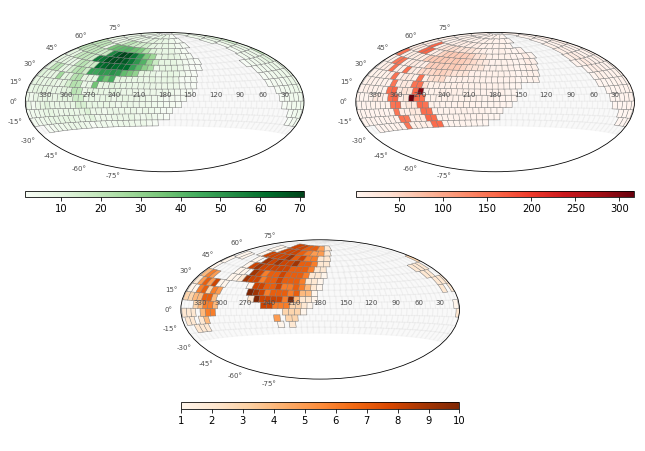

In [4]:
mns.show_gri_fields()